In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')
from glob import glob
from src.utils import *
from src.params import *
import pymc3 as pm
import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
sns.set_style("darkgrid")
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio as rio
import censusdata
from rasterstats import zonal_stats

from sklearn.linear_model import LinearRegression

In [3]:
df, basin_idx, basins, coords = read_data(
    file_dir='../data/hierarchical_septics_v7.csv',
    cols=['ppt_2021', 'hydraulic_c', 'median_hse', 'slope', 'age_median', 'income_median'], 
    is_balanced=True
)

balancing...
repairs: 27.73092578545258%, non-repairs: 72.26907421454743%


# Inspect data

(-85.83725505, -80.61104395, 30.129539656, 35.227167224)

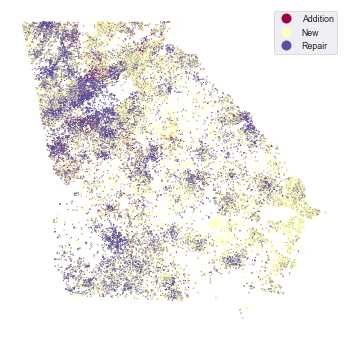

In [4]:
# Plot system distribution
f, ax = plt.subplots(figsize=(8,6))
gdf = pd.read_csv('../data/hierarchical_septics_v7.csv')
gdf = gpd.GeoDataFrame(gdf, geometry=gpd.points_from_xy(gdf['tblSGA_Property.gis_long_property'], gdf['tblSGA_Property.gis_lat_property']))
gdf.plot(column='sewageSystem', categorical=True, legend=True, markersize=0.1, cmap='Spectral', ax=ax)
ax.axis('off')

(-85.8434368, -80.60145719999998, 30.014143699999998, 35.7184863)

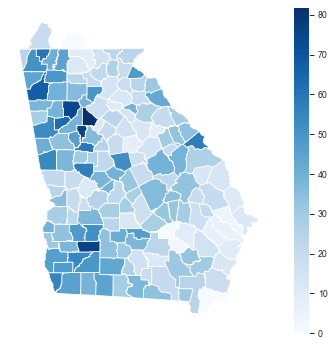

In [5]:
# Plot by county (failure %)
bdry = gpd.read_file('../../Data/boundary/cb_2018_us_county_500k/cb_2018_us_county_500k.shp')
joined = gpd.sjoin(gdf, bdry, how="inner", op="within")

agg_data = joined.groupby('index_right').size()
failure_data = joined[joined['sewageSystem'] == 'Repair'].groupby('index_right').size()

bdry['total_count'] = bdry.index.map(agg_data).fillna(0)
bdry['failure_count'] = bdry.index.map(failure_data).fillna(0)

# Step 3: Calculate Percentage
bdry['percent_failure'] = (bdry['failure_count'] / bdry['total_count']) * 100

# Step 4: Plot
f, ax = plt.subplots(figsize=(8,6))
bdry.plot(column='percent_failure', cmap='Blues', ax=ax, legend=True)
ax.axis('off')

# Check Empirical Distribution
This analysis helps us to inform the distribution property when designing our hierachical Bayesian model e.g., Gaussian, Exponential, Gamma, etc

Predictor 1: Annual Precipitation Maxima

Text(0.5, 0, 'Precipitation (mm)')

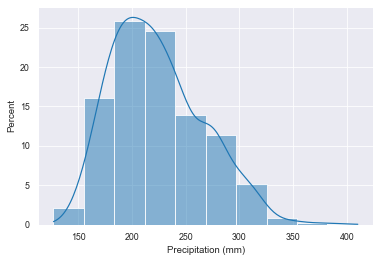

In [6]:
ax = sns.histplot(data=df, x='ppt_2021', stat="percent", bins=10, kde=True, kde_kws={'bw_adjust':3})
ax.set_xlabel('Precipitation (mm)')
# plt.savefig('../docs/precip_dist.pdf', dpi=300)

Predictor 2: Median Housing Values

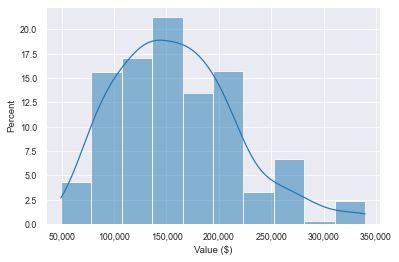

In [7]:
import matplotlib as mpl

ax = sns.histplot(data=df, x='median_hse', stat="percent", bins=10, kde=True, kde_kws={'bw_adjust':4})
ax.set_xlabel('Value ($)')
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
# plt.savefig('../docs/hse_dist.pdf', dpi=300)

Predictor 3: Soil Hydraulics

Text(0.5, 0, 'Soil Hydraulics Conductivity $log_{10}(cm/hr)$')

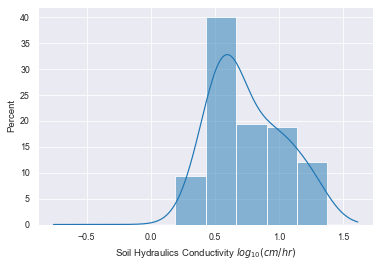

In [8]:
ax = sns.histplot(data=df, x='hydraulic_c', stat="percent", bins=10, kde=True, kde_kws={'bw_adjust':6})
ax.set_xlabel('Soil Hydraulics Conductivity $log_{10}(cm/hr)$')
# plt.savefig('../docs/hydr_dist.pdf', dpi=300)

Predictor 4: Slope

Text(0.5, 0, 'Slope (degrees)')

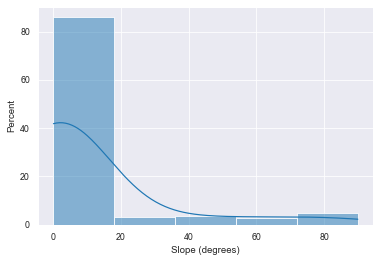

In [9]:
ax = sns.histplot(data=df, x='slope', stat="percent", bins=5, kde=True, kde_kws={'bw_adjust':8})
ax.set_xlabel('Slope (degrees)')
# plt.savefig('../docs/slope_dist.pdf', dpi=300)

Predictor 5: DEM

Text(0.5, 0, 'Topographic elevation (m)')

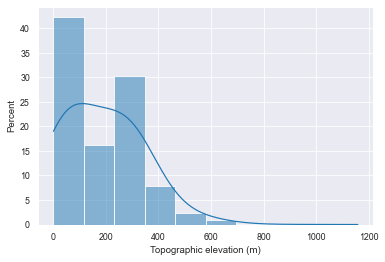

In [10]:
ax = sns.histplot(data=df, x='dem', stat="percent", bins=10, kde=True, kde_kws={'bw_adjust':8})
# ax.set_title('Digital Elevation (m) in Georgia')
ax.set_xlabel('Topographic elevation (m)')
# plt.savefig('../docs/dem_dist.pdf', dpi=300)

Attribute 1: Age median

Text(0.5, 0, 'Age median (year)')

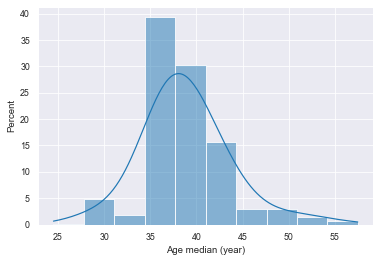

In [11]:
ax = sns.histplot(data=df, x='age_median', stat="percent", bins=10, kde=True, kde_kws={'bw_adjust':8})
ax.set_xlabel('Age median (year)')
# plt.savefig('../docs/age_dist.pdf', dpi=300)

Attribute 2: Income median

Text(0.5, 0, 'Income median ($)')

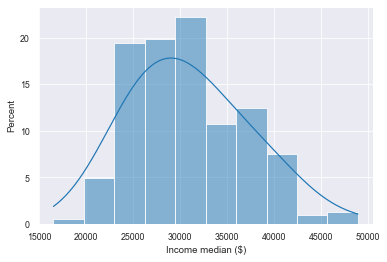

In [12]:
ax = sns.histplot(data=df, x='income_median', stat="percent", bins=10, kde=True, kde_kws={'bw_adjust':8})
ax.set_xlabel('Income median ($)')
# plt.savefig('../docs/income_dist.pdf', dpi=300)

# Wastewater EDA
Examining the system dataset itself...

In [13]:
df = pd.read_csv('../data/hierarchical_septics_v7.csv')

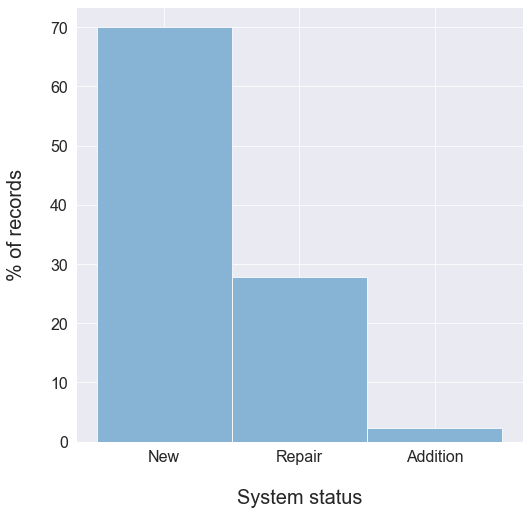

In [14]:
f, ax = plt.subplots(figsize=(8,8))
sns.histplot(data=df, x='sewageSystem', stat="percent", facecolor='#87b3d4')
ax.set_xlabel("System status", labelpad = 24, fontsize=20)
ax.set_ylabel("% of records", labelpad = 24, fontsize=20)
ax.tick_params(labelsize=16);
# f.savefig('../docs/percent_status.pdf', dpi=300, bbox_inches='tight');

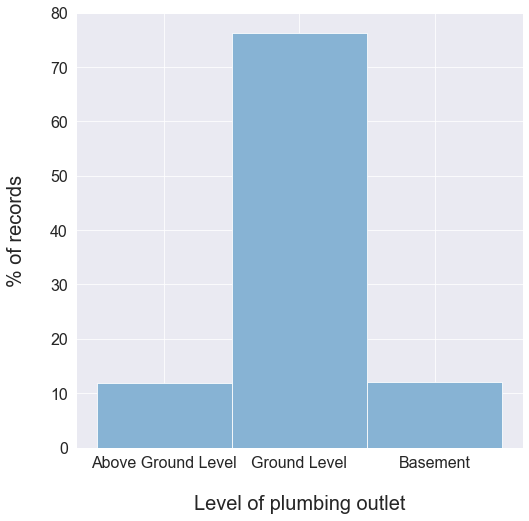

In [15]:
f, ax = plt.subplots(figsize=(8,8))
sns.histplot(data=df, x='levelOfPlumbingOutlet', stat="percent", facecolor='#87b3d4')
ax.set_xlabel("Level of plumbing outlet", labelpad = 24, fontsize=20)
ax.set_ylabel("% of records", labelpad = 24, fontsize=20)
ax.tick_params(labelsize=16);
# f.savefig('../docs/percent_plumbing.pdf', dpi=300, bbox_inches='tight');

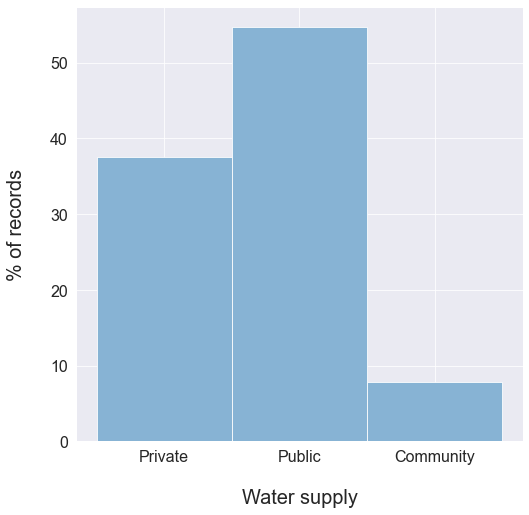

In [16]:
f, ax = plt.subplots(figsize=(8,8))
sns.histplot(data=df[df['waterSupply'] != '3'], x='waterSupply', stat="percent", facecolor='#87b3d4')
ax.set_xlabel("Water supply", labelpad = 24, fontsize=20)
ax.set_ylabel("% of records", labelpad = 24, fontsize=20)
ax.tick_params(labelsize=16);
f.savefig('../docs/percent_watersupply.pdf', dpi=300, bbox_inches='tight');

After random balancing: Wastewater system distribution

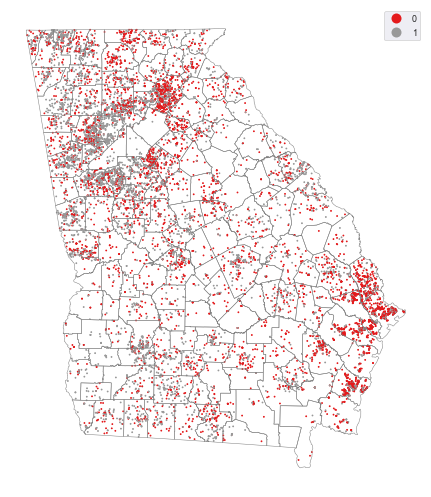

In [17]:
# Random balancing
df = pd.read_csv('../data/hierarchical_septics_v7.csv')

# encode categorical sewage system
enc, _ = pd.factorize(df['sewageSystem'])
df['sewageSystem_enc'] = enc
df.loc[df['sewageSystem_enc'] == 1, 'sewageSystem_enc'] = 1 # need repair
df.loc[(df['sewageSystem_enc'] == 0) | (df['sewageSystem_enc'] == 2), 'sewageSystem_enc'] = 0 # new + addition

# random balancing: concat between (1) samples randomly drawn from the entire set + (2) few-shot class
# upside: keeps the number of records allowing for better big data analysis
# downside: duplicates on the few-shot class (akin to multiple-epoch gradient descent passes)
idx = df[df['sewageSystem_enc'] == 0]
df = pd.concat((df.sample(n=len(idx), random_state=42), df[df['sewageSystem_enc'] == 1]))

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['tblSGA_Property.gis_long_property'], df['tblSGA_Property.gis_lat_property']))

# plot samples
gdf.set_crs('EPSG:4326', inplace=True)
f, ax = plt.subplots(figsize=(7,7))
sampled_gdf = gdf.sample(n=12000)
sampled_gdf.plot(column='sewageSystem_enc', categorical=True, cmap='Set1', markersize=1, legend=True, ax=ax)
ax.axis('off')
f.tight_layout()

# plot county boundary
boundary_f = '../../Data/boundary/cb_2018_us_county_500k/cb_2018_us_county_500k.shp'
bdry = gpd.read_file(boundary_f)
state_bdry = bdry[bdry['STATEFP'] == '13']
state_bdry.boundary.plot(edgecolor='grey', linewidth=0.5, ax=ax);

# f.savefig('../docs/ga_system_dist.pdf', dpi=300, bbox_inches='tight');

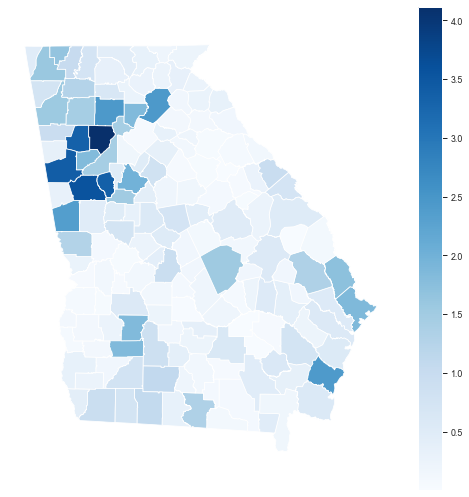

In [18]:
# Plot percentage of system failures at each county (after balancing...)
f, ax = plt.subplots(figsize=(7,7))
failing_gdf = gdf[gdf['sewageSystem_enc'] == 1]
combined_df = failing_gdf.sjoin(state_bdry, how='left')
failing_size = combined_df.groupby('NAME').size()
failing_perc = failing_size / sum(failing_size) * 100
failing_perc = failing_perc.reset_index()
failing_perc = failing_perc.rename(columns={0: 'failing_percentage'})
state_bdry = state_bdry.merge(failing_perc, on='NAME')
state_bdry.plot(column='failing_percentage', ax=ax, cmap='Blues', legend=True)
ax.axis('off');
f.tight_layout();

# Correlation of predictors X and attributes Z
This analysis is helpful to help us design hierarchical Bayesian model between the attributes and predictors. For example, if there is non-significant correlation between the two, then we would not encode the relationship (e.g., between slope and income). To recap, the attributes are used to modulate our predictors in an out-of-state inference...

In [19]:
def get_inference_data(indep_srcs, state_id):
    def _get_acs_df(dict):
        acs = (censusdata.download(
            acs_dict['type'],acs_dict['year'], 
            censusdata.censusgeo([('state', acs_dict['state']), ('county', '*')]), [acs_dict['code']]
        ).reset_index().rename(columns={acs_dict['code']: acs_dict['col_name']}))

        for i, row in acs.iterrows():
            county = (str(row['index'])
                        .split(',')[0]
                        .split('County')[0]
                        .strip())

            acs.loc[i, 'County'] = county
        
        for i, row in state_bdry.iterrows():
            try:
                hse_mean = acs[acs['County'] == row['NAME']][acs_dict['col_name']].item()
                state_bdry.loc[i, acs_dict['col_name']] = hse_mean
            except:
                state_bdry.loc[i, acs_dict['col_name']] = 0

    state_id = str(state_id)

    # Get boundary
    bdry = gpd.read_file(indep_srcs['bdry'])
    state_bdry = bdry[bdry['STATEFP'] == state_id].reset_index(drop=True)
    outer_bdry = state_bdry.dissolve()
    del indep_srcs['bdry']

    # Get raster median value for each county
    for indep_var in indep_srcs.keys():
        filename = indep_srcs[indep_var]
        with rio.open(filename) as src:
            affine = src.transform
            array = src.read(1)
            
            # convert to slope
            if indep_var == 'slope':
                array = np.where(array == 32767, np.nan, array)
                res = src.res[0]  # pixel resolution in degrees
                elevation_deg = np.degrees(np.arctan(array / np.sqrt(res**2 + res**2)))
                slope_x, slope_y = np.gradient(elevation_deg, res, res)
                array = np.degrees(np.arctan(np.sqrt(slope_x**2 + slope_y**2)))
                
            zones = pd.DataFrame(zonal_stats(state_bdry, array, affine=affine, stats='median'))
        
        var_name = f'{indep_var}_median'
        state_bdry[var_name] = zones['median']

    # Get censusdata value
    acs_dict_list = [
        {'type': 'acs5','year': 2021,'state': state_id,'code': 'B25077_001E','col_name': 'hse_median'}, 
        {'type': 'acs1','year': 2021,'state': state_id,'code': 'B17002_002E','col_name': 'poverty_income_ratio'},
        {'type': 'acs5','year': 2021,'state': state_id,'code': 'B01003_001E','col_name': 'population_size'},
        {'type': 'acs5','year': 2021,'state': state_id,'code': 'B06002_001E','col_name': 'age_median'},
        {'type': 'acs5','year': 2021,'state': state_id,'code': 'B07411_001E','col_name': 'income_median'}
    ]
    for acs_dict in acs_dict_list:
        _get_acs_df(acs_dict)

    # Normalize poverty_income_ratio with population size
    state_bdry['poverty_income_ratio'] = state_bdry['poverty_income_ratio'] / state_bdry['population_size']
    
    return state_bdry

In [20]:
# Preprocess all variables (predictors + attributes)
state_id = state_codes['GA']
indep_srcs = {
    'bdry': '../../Data/boundary/cb_2018_us_county_500k/cb_2018_us_county_500k.shp',
    'ppt': '../../Data/precipitation/annual_max_2021.tif',
    'soil': '../../Data/soil/mosaic/GA.tif',
    'slope': '../../Data/dem/hyd_na_dem_15s.tif',
}
gdf = get_inference_data(indep_srcs, state_id=state_id)
for var in ['ppt_median', 'soil_median', 'slope_median', 'hse_median', 'poverty_income_ratio', 'age_median', 'income_median']:
    gdf[var] = (gdf[var] - gdf[var].mean()) / gdf[var].std() # z-normalize
gdf.reset_index(drop=True, inplace=True)
gdf.fillna(0., inplace=True)

In [21]:
# Ablation 1: Perform pairwise correlation between raw variables
A_cols = ['ppt_median', 'soil_median', 'slope_median', 'hse_median']
B_cols = ['poverty_income_ratio', 'age_median', 'income_median']
A = gdf[A_cols+B_cols].to_numpy()
B = gdf[A_cols+B_cols].to_numpy()
N = B.shape[0]
sig = 2/np.sqrt(N)

# Store columnw-wise in A and B, as they would be used at few places
sA = A.sum(0)
sB = B.sum(0)

# Basically there are four parts in the formula. We would compute them one-by-one
p1  = N*np.dot(B.T,A)
p2 = sA*sB[:,None]
p3 = N*((B**2).sum(0)) - (sB**2)
p4 = N*((A**2).sum(0)) - (sA**2)

# Finally compute Pearson Correlation Coefficient as 2D array with statistical significance
pcorr = ((p1 - p2)/np.sqrt(p4*p3[:,None]))
df = pd.DataFrame(pcorr, columns=A_cols+B_cols, index=A_cols+B_cols)
df[abs(df) > sig]

,ppt_median,soil_median,slope_median,hse_median,poverty_income_ratio,age_median,income_median
ppt_median,1.000000,0.279019,0.233823,NaN,NaN,NaN,-0.258821
soil_median,0.279019,1.000000,NaN,-0.466070,NaN,-0.165681,-0.364264
slope_median,0.233823,NaN,1.000000,NaN,NaN,NaN,NaN
hse_median,NaN,-0.466070,NaN,1.000000,0.350666,NaN,0.866404
poverty_income_ratio,NaN,NaN,NaN,0.350666,1.000000,-0.452733,0.373931
age_median,NaN,-0.165681,NaN,NaN,-0.452733,1.000000,-0.225728
income_median,-0.258821,-0.364264,NaN,0.866404,0.373931,-0.225728,1.000000


In [22]:
# Ablation 2: Perform pairwise correlation between regressed variables (i.e., cleaner; conclusion unchanged)
y_cols = ['ppt_median', 'soil_median', 'slope_median', 'hse_median']
x_cols = ['poverty_income_ratio', 'age_median', 'income_median']

coeffs = list()
intercepts = list()
for y_col in y_cols:
    coeffs.append(LinearRegression().fit(gdf[x_cols], gdf[y_col]).coef_)
    intercepts.append(LinearRegression().fit(gdf[x_cols], gdf[y_col]).intercept_)

df = pd.DataFrame(np.array(coeffs), columns=x_cols, index=y_cols)
df['intercept'] = np.array(intercepts)
df[abs(df) > sig]

,poverty_income_ratio,age_median,income_median,intercept
ppt_median,NaN,NaN,-0.246727,NaN
soil_median,NaN,-0.312900,-0.385096,NaN
slope_median,NaN,NaN,NaN,NaN
hse_median,NaN,0.209811,0.868567,NaN
